This notebook is modified from the example [python file](https://scikit-learn.org/0.15/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py) written by Eustache Diemert (<eustache@diemert.fr>) from scikit-learn.org.

## Import libraries

In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import six
import sys
sys.modules['sklearn.externals.six'] = six

from six.moves import html_parser
from six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

In [3]:
import sklearn
print(sklearn.__version__)

1.3.0


In [4]:
def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

## Reuters Dataset related routines

In [5]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""

In [6]:
def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

In [7]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2**18, alternate_sign=False)

In [8]:
# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

In [9]:
# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

In [10]:
def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)

In [11]:
def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In [12]:
# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

In [13]:
# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

downloading dataset (once and for all) into /root/scikit_learn_data/reuters
untarring Reuters dataset...
done.
Test set is 969 documents (155 positive)


## Training

In [14]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

In [15]:
# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

In [16]:
cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

In [17]:
get_minibatch(data_stream, n_test_documents)
# Discard test set

(('BAHIA COCOA REVIEW\n\nShowers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit fo

In [18]:
# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

In [19]:
# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

In [20]:
# Main loop : iterate on mini-batchs of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')


                 SGD classifier : 	   973 train docs (   125 positive)    969 test docs (   155 positive) accuracy: 0.913 in 9.86s (   98 docs/s)
          Perceptron classifier : 	   973 train docs (   125 positive)    969 test docs (   155 positive) accuracy: 0.912 in 9.89s (   98 docs/s)
      NB Multinomial classifier : 	   973 train docs (   125 positive)    969 test docs (   155 positive) accuracy: 0.840 in 9.97s (   97 docs/s)
  Passive-Aggressive classifier : 	   973 train docs (   125 positive)    969 test docs (   155 positive) accuracy: 0.905 in 9.99s (   97 docs/s)


                 SGD classifier : 	  3363 train docs (   424 positive)    969 test docs (   155 positive) accuracy: 0.920 in 11.84s (  283 docs/s)
          Perceptron classifier : 	  3363 train docs (   424 positive)    969 test docs (   155 positive) accuracy: 0.901 in 11.85s (  283 docs/s)
      NB Multinomial classifier : 	  3363 train docs (   424 positive)    969 test docs (   155 positive) accuracy: 0.84

## Plotting Results

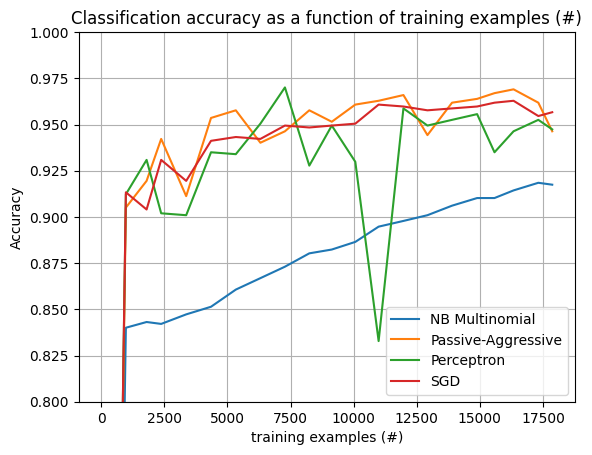

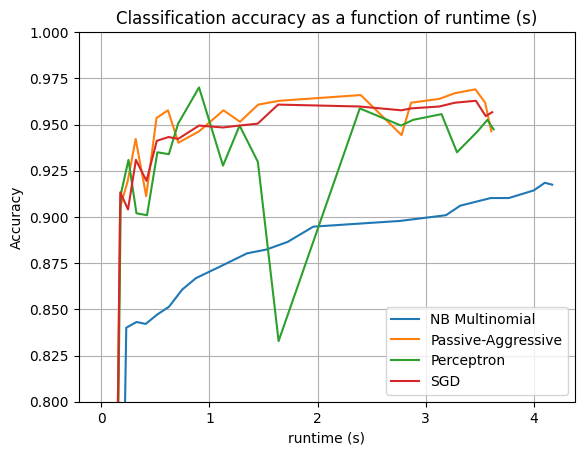

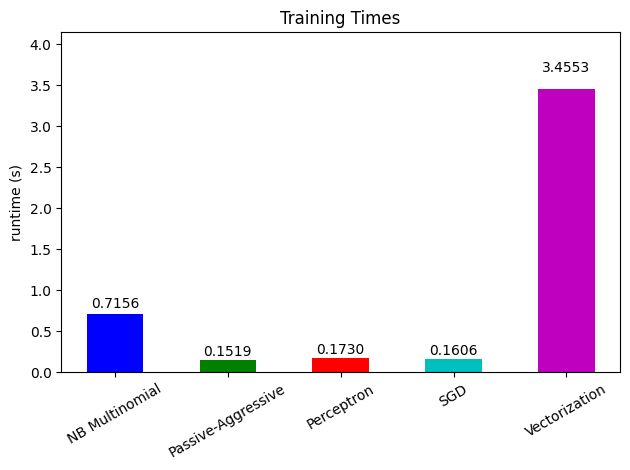

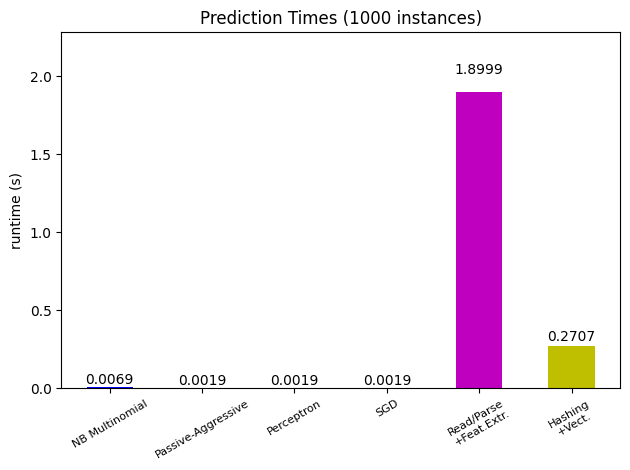

In [21]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title("Classification accuracy as a function of %s" % x_legend)
    plt.xlabel("%s" % x_legend)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.plot(x, y)


rcParams["legend.fontsize"] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats["accuracy_history"])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats["runtime_history"])
    plot_accuracy(runtime, accuracy, "runtime (s)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats["total_fit_time"] for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append("Vectorization")
bar_colors = ["b", "g", "r", "c", "m", "y"]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Training Times")


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            1.05 * height,
            "%.4f" % height,
            ha="center",
            va="bottom",
        )
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats["prediction_time"])
cls_runtime.append(parsing_time)
cls_names.append("Read/Parse\n+Feat.Extr.")
cls_runtime.append(vectorizing_time)
cls_names.append("Hashing\n+Vect.")

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Prediction Times (%d instances)" % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()